In [1]:
from utils import *

In [2]:
model_name = "roberta-base" #"roberta-base" #"albert-base-v1" #"bert-base-uncased"  
tokenizer = AutoTokenizer.from_pretrained(model_name)
path = untar_data(URLs.IMDB_SAMPLE)
df_label = pd.read_csv(path/'texts.csv')

In [3]:
%time dls_lm = BertTextDataLoaders.from_df(df_label, model_name, path=path, bs=16, text_col='text', is_lm=True)
dls_lm.show_batch(max_n=2)

Wall time: 6.13 s


,text,text_
0,i [MASK]t help it but i seem to like films [MASK] are [MASK] to [MASK] scary [MASK] are just plain bad [MASK] i have personally listed it in my own top 10 worst movies right under lithuania of the abyss!. watch [MASK] film and have a laugh just don't expect to see any academy awards for acting. [MASK] chance [MASK] [MASK] the [MASK] its self. in [MASK] honesty though i have seen much worse than this. plus some maniac [MASK] round the desert wiping the same people zombies that just died is that unbelievable that its [MASK] to be original. i think its [MASK] of [MASK] love or hate gamma. you can make up your elevation mind yes its awful [MASK] it pulls it off somehow thats why i love it this has got to be [MASK] worst horror movie i [MASK] ever seen. i remember [MASK] it years ago,[PAD] cant [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] that [PAD] meant [PAD] be [PAD] and [PAD] [PAD] [PAD] [PAD]. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] creatures [PAD] [PAD] abyss [PAD] [PAD] [PAD] this [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] more [PAD] of understanding [PAD] film [PAD] [PAD] [PAD] [PAD] all [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] some [PAD] [PAD] cruising [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] out [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] got [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] one [PAD] those [PAD] [PAD] [PAD] movies [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] own [PAD] [PAD] [PAD] [PAD] but [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] the [PAD] [PAD] [PAD]
1,"( [MASK] terrific ) [MASK] she's a widow who can't move on, he's illiter [MASK] and a closet - inventor - - you can probably [MASK] the rest. adaptation of pat barker's novel "" union street "" ( [MASK] better title! ) is so thirties - [MASK] it verges on bland [MASK] and the film's editing is a mess, but it's still pleasant ; a rosy [MASK] hued blue - collar fantasy. there capsule no overtures to serious [MASK] ( even the illiteracy [MASK] is just [MASK] plot - tool for the ensuing [MASK] story ) and no real fireworks, though the [MASK] are intentionally a bit colorless and the leads are toned down to an interesting [MASK]. [MASK] finale [MASK] pure fluff - - and cynic [MASK] will find it difficult to swallow [MASK] - though these two characters deserve a [MASK] twisting and the picture wouldn't really be","[PAD] both [PAD] [PAD]. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]ate [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] guess [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] laid [PAD] back [PAD] [PAD] [PAD] [PAD] [PAD], [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] - [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] are no [PAD] [PAD] [PAD] [PAD] issues [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] angle [PAD] [PAD] a [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] love [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] characters [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] degree [PAD] the [PAD] is [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

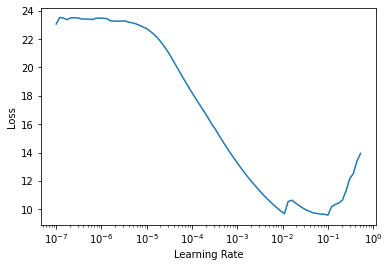

In [4]:
model_lm = AutoModelForMaskedLM.from_pretrained(model_name)
opt = partial(Adam, decouple_wd=True)
loss = CrossEntropyLossFlat()
splitter_nm = 'roberta_lm_splitter'#'_lm_splitter'
model_splitter = splitters[splitter_nm]
learn_lm = BertTextLearner(dls_lm, model_lm, opt_func=opt, splitter=model_splitter, loss_func=loss, cbs=[DropOutput], metrics=[accuracy, perplexity]).to_fp16()
learn_lm.lr_find()

In [5]:
learn_lm.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,11.827749,8.375313,0.016624,4338.625000,00:32


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.778853,0.670738,0.895383,1.955679,00:50
1,1.165282,1.133393,0.873686,3.106178,00:52
2,1.177930,1.145638,0.874965,3.144447,00:49
3,1.165581,1.186963,0.874482,3.277114,00:51
4,1.113412,1.151867,0.873473,3.164096,00:50


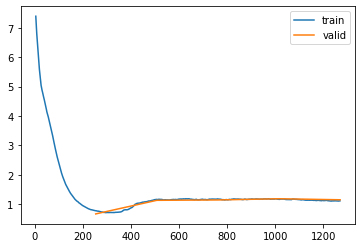

In [6]:
learn_lm.recorder.plot_loss()

In [7]:
current_path = Path(".")

In [8]:
learn_lm.predict("Beijing is capital of [MASK].")

('[PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 tensor([  0,   0,   0,   0,   0,   0,   0, 102]),
 tensor([[9.4701e-01, 1.1492e-12, 1.0966e-12,  ..., 7.3466e-14, 2.4608e-14,
          8.5043e-15],
         [9.8639e-01, 1.8939e-13, 1.6977e-13,  ..., 1.4378e-14, 3.8098e-15,
          1.0915e-15],
         [9.9028e-01, 8.9816e-14, 7.8033e-14,  ..., 6.8185e-15, 1.8934e-15,
          4.5681e-16],
         ...,
         [1.2351e-01, 8.6120e-10, 9.1674e-10,  ..., 3.6106e-11, 2.0572e-11,
          3.3392e-11],
         [9.9085e-01, 8.3113e-14, 7.2210e-14,  ..., 6.5100e-15, 1.6982e-15,
          4.8655e-16],
         [9.5122e-02, 2.8733e-14, 2.4196e-14,  ..., 2.4718e-15, 6.1527e-16,
          9.9659e-17]]))

In [ ]:
learn_lm.save_encoder(current_path/"finetune base")
learn_lm.save(current_path/"lang model")
learn_lm.export(current_path/"lang model.pkl")

In [ ]:
# classifaction

In [9]:
%time dls_class = BertTextDataLoaders.from_df(df_label, model_name, path=path, bs=16, text_col='text', label_col='label')
dls_class.show_batch(max_n=1)

Wall time: 5.63 s


,text,category
0,"this film appears to draw a borderline - on one side, those who love it, on the other, those who find it unbearable. < br / > < br / > to begin with, there is an awful lot of comedy in this film that many viewers are not "" getting "". of course jet li's mask looks like bruce lee's kato - he's supposed to, it's a joke. the guy who has a time - bomb sewn to his heart - outrageous? of course, it's a joke! some readers will probably ask, if this film is supposed to be so funny, why all the excessive and gory violence? well, for one thing the tolerance for this level of violence is actually different, from culture to culture ; and while hong kong audiences would recognize this violence is extreme, it's certainly only slightly more than average for a hk action",positive


In [10]:
model_class = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = dls_class.c)
splitter_nm = "roberta_cls_splitter" #.split('/')[1]
model_splitter = splitters[splitter_nm]
loss = LabelSmoothingCrossEntropy()
opt = partial(Adam, decouple_wd=True)
learn_class = Learner(dls_class, model_class, opt_func=opt, loss_func=loss,
                splitter = model_splitter, cbs=[DropOutput], metrics=[accuracy]).to_fp16()

Some weights of the model checkpoint at E:/02models/huggingface-model/pytorch/distilbert were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at E:/02models/huggingface-model/pytorch/distilbert and are newly initialized: ['pre_

In [11]:
learn_class.validate()

RuntimeError: DataLoader worker (pid(s) 16612, 10536, 15344, 3700, 14340, 4824, 17128, 9448, 14488, 7864, 1260, 12200) exited unexpectedly

In [12]:
learn_class.lr_find()

RuntimeError: DataLoader worker (pid(s) 14416, 3988, 8772, 9464, 8592, 12168, 16988, 1472, 4136, 16808, 16876, 8852) exited unexpectedly

In [ ]:
learn_class.fine_tune(5)

In [ ]:
learn_class.recorder.plot_loss()

In [ ]:
learn_class.show_results(max_n=5)

In [ ]:
learn_class.predict("this is a good news!")